# 1. Необходимо, чтобы "Data" и "Settings" справа выглядели также (должны быть включены GPU и Internet и нужно, чтобы присутствовать папка с подготовленными данными) 

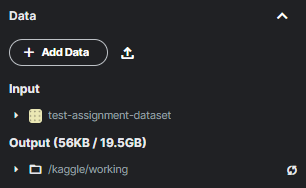 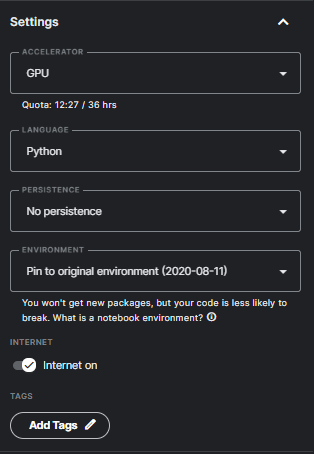!

# 2. Настройка ноутбука, установка darknet

In [ ]:
# Getting info about current GPU
!nvidia-smi

# OpenCV configuration
!apt update
!apt install --yes python-opencv
!apt install --yes libopencv-dev
!/bin/bash -c 'echo "/opt/conda/lib/" > /etc/ld.so.conf.d/opencv.conf'
!ldconfig

# Importing dependencies
import matplotlib.pyplot as plt
import cv2

# Verifying CUDA
!/usr/local/cuda/bin/nvcc --version

# Cloning darknet repo
!git clone https://github.com/AlexeyAB/darknet
    
# Enabling OpenCV, GPU, CUDNN and CUDNN_HALF
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

# Resolving the error of lcuda.h by successfully creating a symlink to that file
!ln -s /usr/local/nvidia/lib64/libcuda.so /usr/local/cuda/lib64/libcuda.so

# Building darknet
!make

# Defining helper funtion
def showImage(path, show=True):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if show:
        plt.imshow(image)
    else:
        return image

Mon Oct 17 00:22:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##  Инференс сети на изображении из самого фреймворка

In [ ]:
# get pretrained weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
# run darknet
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg -dont_show
showImage('predictions.jpg')

# 3. Настройка чтения/сохранения данных

In [ ]:
%cd /kaggle/
!ls  

In [ ]:
import logging
import sys
import os
import shutil


def copy_input_files_2_output_dir(src_dir, dst_dir):

    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    for item in os.listdir(src_dir):
        item_path = os.path.join(src_dir, item)
        save_path = os.path.join(dst_dir, item)
        if os.path.isdir(item_path):
            shutil.copytree(item_path, save_path)
        else:
            shutil.copyfile(item_path, save_path)
    
    src_dir_files, dst_dir_files = set(os.listdir(src_dir)), set(os.listdir(dst_dir))
#     assert src_dir_files == dst_dir_files, (src_dir_files, dst_dir_files)
    logger.info(f'successfuly copied all files from {src_dir} to {dst_dir}')

def init_logger():
    # define logger  
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    return logger
    
def showImage(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)


logger = init_logger()
copy_input_files_2_output_dir(src_dir='input/test-assignment-dataset/data', dst_dir='working/darknet/data')
copy_input_files_2_output_dir(src_dir='input/test-assignment-dataset/cfg', dst_dir='working/darknet/cfg')

## Инференс до обучения сети (с предобученными весами из darknet)

In [ ]:
# check mAP before training (with pretrained weights from darknet)
%cd /kaggle/working/darknet
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg yolov4.weights

In [ ]:
%cd /kaggle/
!ls

In [ ]:
# make copy of best weights for easy access when loading them for inference
copy_input_files_2_output_dir(src_dir='input/test-assignment-dataset/best_weights', dst_dir='working/best_weights')

## Инференс с лучшими полученными весами

In [ ]:
# check mAP after training (with our weights from training)
%cd /kaggle/working/darknet
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg ../best_weights/yolov4-obj_best_3.weights

## Пример предсказаний на тестовом изображении

In [ ]:
# Test on random image from test set
# set cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
%cd ..

# run Net
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg ../best_weights/yolov4-obj_best_3.weights ./data/test_set/2_0000006.jpg -thresh 0.3
showImage('predictions.jpg')

In [ ]:
# Остановка после инференса с лучшими весами
assert False 

# 4. Обучение

In [ ]:
""" 
Stops Running here if you ran Notebook by pressing Run All;
This stop is needed to choose between next two cells and run the correct one:
- if you want to train from start (with yolo pretrained weights, then run next cell); 
- if you want to continue training with your saved weights upload weights to Input, '../input/test-assignment-dataset/saved_weights/' dir, then run cell, which is next to the next one.
"""

# assert False 

## Обучение с самого начала (с pretrained весами из darknet)

In [ ]:
%cd /kaggle/working/darknet
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg yolov4.conv.137 -dont_show -map >> ../kaggle_train_resolution_512.log

## Продолжение обучения с сохраненными весами (загружаются из Input, '../input/test-assignment-dataset/saved_weights/')

In [ ]:
%cd /kaggle
!mkdir ./working/saved_weights/
!cp ./input/test-assignment-dataset/saved_weights/yolov4-obj_last.weights ./working/saved_weights/yolov4-obj_last.weights

%cd /kaggle/working/darknet
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg ../saved_weights/yolov4-obj_last.weights -dont_show -map >> ../kaggle_train_resolution_512.log

# 5. Инференс

In [ ]:
# make copy of best weights for easy access when loading them for inference
copy_input_files_2_output_dir(src_dir='input/test-assignment-dataset/best_weights', dst_dir='working/best_weights')

In [ ]:
# check mAP before training (with pretrained weights from darknet)
%cd /kaggle/working/darknet
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg yolov4.weights

In [ ]:
# check mAP after training (with our weights from training)
%cd /kaggle/working/darknet
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg ../best_weights/yolov4-obj_best_3.weights 

In [ ]:
# Test on random image from test set
# set cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
%cd ..

# run Net
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg ../best_weights/yolov4-obj_best_3.weights ./data/test_set/2_0000006.jpg -thresh 0.3
showImage('predictions.jpg')

In [ ]:
# visualize predictions for random images from test set
!mkdir ../predictions_thr_0_5

import numpy as np
np.random.seed(0)

test_images = [img_name for img_name in os.listdir("./data/test_set/") if img_name.endswith('.jpg')]
random_images = np.random.choice(test_images, 5, replace=False)

for i, image_name in enumerate(random_images):
    image_full_path = os.path.join("./data/test_set/", image_name)
    print(i, image_name)

In [ ]:
%cd /kaggle/working/darknet
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg ../best_weights/yolov4-obj_best_3.weights ./data/test_set/2_067.jpg -thresh 0.5
shutil.copyfile('predictions.jpg', f'../predictions_thr_0_5/2_067.jpg')
# showImage('predictions.jpg')

## Сохранение примеров инференса 

In [ ]:
import tarfile

tar = tarfile.open(f'/kaggle/working/predictions_thr_0_5.tar.gz', 'w:gz')
tar.add('/kaggle/working/predictions_thr_0_5')
tar.close()

# 6. Сохранение весов и логов в .zip файл для скачивания (из Output, '/kaggle/working')

In [ ]:
files_to_save = os.listdir('/kaggle/working/')
tar = tarfile.open(f'training_results.tar.gz', 'w:gz')
for item in files_to_save:
    file_full_path = os.path.join('/kaggle/working/', item) 
    if not os.path.isdir(file_full_path):
        try:
            tar.add(file_full_path)
        except:
            print(file_full_path)

tar.close()